In [155]:
%reset 


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [156]:
%run  ./Kickit_app_transformers.py

In [157]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import warnings
import pickle
import dtale
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

# Reading the Data set

In [158]:
# reading the dataset
df_raw = pd.read_csv('kick.csv')

Extracting the axis of studies for the project custom to  ADESA website 

In [159]:
choosen_axis = ["Model", "Make" ,"Transmission","VehOdo","MMRAcquisitionAuctionAveragePrice", "IsBadBuy"]
df_adesa_raw = df_raw[choosen_axis]

df_adesa_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72983 entries, 0 to 72982
Data columns (total 6 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Model                              72983 non-null  object
 1   Make                               72983 non-null  object
 2   Transmission                       72983 non-null  object
 3   VehOdo                             72983 non-null  int64 
 4   MMRAcquisitionAuctionAveragePrice  72983 non-null  object
 5   IsBadBuy                           72983 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 3.3+ MB


In [160]:
dtale.show(df_adesa_raw)

# Pre-processing Pipeline for the freqency encoding technique

In [161]:
df = df_adesa_raw.copy()

 Instantiating the preprocessing pipeline objects

In [162]:
'''this on will clean the dataset'''
f_preprocess = Kickit_dataframe_preprocessor()
'''this one will balance the dataset''' 
f_balancer = Kickit_dataframe_balancer()
''' this one will use the frequency encoding technique for categorical variable ''' 
freq_encoder = Kickit_frequency_encoder()

Creating a pipeline for the first preprocessing technique :based on count of  frequency encoder

In [163]:
freq_pipeline = Pipeline([("preprocess",f_preprocess),("balancer", f_balancer),
                          ("fencoder",freq_encoder)])

preprocessing the dataframe with the count of frequency pipeline

In [164]:
adesa_freq_pipe = freq_pipeline.fit_transform(df)

checking the transformation for success

In [165]:
adesa_freq_pipe.head(5)

,Model,Make,Transmission,VehOdo,MMRAcquisitionAuctionAveragePrice,IsBadBuy,Model_encoded,Make_encoded
0,MAZDA3,MAZDA,1,89046,8155.0,0,42,267
1,1500 RAM PICKUP 2WD,DODGE,1,93593,6854.0,0,230,2923
2,STRATUS V6,DODGE,1,73807,3202.0,0,138,2923
3,NEON,DODGE,1,65617,1893.0,0,135,2923
4,FOCUS,FORD,0,69367,3913.0,0,244,2977


In [166]:
adesa_freq_pipe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17724 entries, 0 to 17723
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Model                              17724 non-null  object 
 1   Make                               17724 non-null  object 
 2   Transmission                       17724 non-null  object 
 3   VehOdo                             17724 non-null  int64  
 4   MMRAcquisitionAuctionAveragePrice  17724 non-null  float64
 5   IsBadBuy                           17724 non-null  int64  
 6   Model_encoded                      17724 non-null  int64  
 7   Make_encoded                       17724 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 1.1+ MB


###  Modelization based on frequency count

preparing and spliting the dataset for the modelization

In [167]:
features = adesa_freq_pipe.drop("IsBadBuy", axis =1)
target = adesa_freq_pipe["IsBadBuy"]
x_ftrain, x_ftest, y_ftrain, y_ftest = train_test_split(features, target, test_size=0.25, random_state=0)

Creating a list of pipelines for three different candidate classifiers

In [168]:
f_scaler = StandardScaler()
f_randomForest = RandomForestClassifier()
f_logisticRegr = LogisticRegression(random_state=0)
f_decisionTree = DecisionTreeClassifier()

freq_bench_cross = [Pipeline([("scaler",f_scaler), ('lr_classifier', f_logisticRegr)]),
                    Pipeline([('dt_classifier', f_decisionTree)]),
                    Pipeline([('rf_classifier', f_randomForest)])] 

In [169]:
# Dictionary of pipelines and classifier types for ease of reference
freq_pipe_dict = {0: 'Logistic Regression', 1: 'Decision Tree', 2: 'RandomForest'}

# Fit the pipelines
for pipe in freq_bench_cross:
    pipe.fit(x_ftrain.drop(["Model", "Make"], axis =1), y_ftrain)

In [170]:
for i,model in enumerate(freq_bench_cross):
    print("{} with count of frequency Test Accuracy: {}".format(freq_pipe_dict[i],model.score(x_ftest.drop(["Model", "Make"], axis =1),y_ftest)))

Logistic Regression with count of frequency Test Accuracy: 0.5899345520198601
Decision Tree with count of frequency Test Accuracy: 0.5508914466260438
RandomForest with count of frequency Test Accuracy: 0.584518167456556


# Pipelines for the Weight of Evidence  encoding technique

### Preprocessing the dataframe with the weight of evidence pipeline

 Instantiating the pipeline object

In [171]:
# this on will clean the data with respect to our requirements
w_preprocess = Kickit_dataframe_preprocessor()
# this one will balance the dataset
w_balancer = Kickit_dataframe_balancer()
# # this one will use the weight of evidence encoding technique for categorical variable 
woe_encoder = Kickit_weight_of_evidence_encoder()

#Creating a pipeline for the second  preprocessing technique :based on the weight of evidence encoder

In [172]:
woe_pipeline = Pipeline([("preprocess",w_preprocess),("balancer", w_balancer),
                         ("woe_encoder", woe_encoder),("2nd balancer", w_balancer)])

preprocessing the dataframe with the weight of evidence pipeline

In [173]:
# the next command  after this will raise an unecessary warning message, this will help keep the notebook clean
warnings.filterwarnings('ignore')

In [174]:
adesa_woe_pipe = woe_pipeline.fit_transform(df)

In [175]:
adesa_woe_pipe['IsBadBuy'].sum()

8180

In [176]:
# checking results
adesa_woe_pipe.head(5)

,Model,Make,Transmission,VehOdo,MMRAcquisitionAuctionAveragePrice,IsBadBuy,Model_encoded,Make_encoded
0,MAZDA3,MAZDA,1,89046,8155.0,0,0.376478,-0.256720
1,1500 RAM PICKUP 2WD,DODGE,1,93593,6854.0,0,-0.156161,0.199403
2,STRATUS V6,DODGE,1,73807,3202.0,0,0.499331,0.199403
3,NEON,DODGE,1,65617,1893.0,0,-0.590075,0.199403
4,FOCUS,FORD,0,69367,3913.0,0,-0.570053,-0.288186


In [177]:
# Checking the dictionary from our encoding class created for each category
woe_cat_dict

{'1500 RAM PICKUP 2WD': -0.15616073075528253,
 '1500 RAM PICKUP 4WD': -0.3677247801253174,
 '1500 SIERRA PICKUP 2': 0.4895482253187058,
 '1500 SILVERADO PICKU': 0.7073318155519017,
 '2500 RAM PICKUP 2WD': -0.5108256237659907,
 '2500HD SILVERADO PIC': -0.587786664902119,
 '300': 0.8226812327518476,
 '300 2.7L V6 MPI': 1.0986122886681098,
 '300M': -1.0986122886681098,
 '300M 3.5L V6 MPI': -0.8472978603872037,
 'ACCENT': -0.04348511193973878,
 'ACCENT 1.6L I4 MPI': -0.4228568508200336,
 'ACCORD 4C': 0.5877866649021191,
 'ACCORD 4C 2.4L I-4 M': 0.8472978603872037,
 'ACCORD V6': 0.8209805520698303,
 'ACCORD V6 3.0L V6 EF': 0.5877866649021191,
 'ALERO 4C': 0.14842000511827322,
 'ALERO 4C 2.2L I4 MPI': -0.7884573603642702,
 'ALERO V6': -1.466337068793427,
 'ALERO V6 3.4L V6 MPI': -0.6359887667199967,
 'ALTIMA': 0.17010596902583072,
 'ALTIMA 2.5L I4 EFI': -0.9382696385929302,
 'ALTIMA 2.5L I4 MPI': 0.23180161405732438,
 'AMANTI': 0.5877866649021191,
 'AMANTI 3.5L V6 MPI': -0.25131442828090605,

In [178]:
adesa_woe_pipe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16360 entries, 0 to 16359
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Model                              16360 non-null  object 
 1   Make                               16360 non-null  object 
 2   Transmission                       16360 non-null  object 
 3   VehOdo                             16360 non-null  int64  
 4   MMRAcquisitionAuctionAveragePrice  16360 non-null  float64
 5   IsBadBuy                           16360 non-null  int64  
 6   Model_encoded                      16360 non-null  float64
 7   Make_encoded                       16360 non-null  float64
dtypes: float64(3), int64(2), object(3)
memory usage: 1022.6+ KB


# Feature ingineering

In [179]:
dtale.show(adesa_woe_pipe)

# MAKE feature engineered

Let's see the frequency count of Make

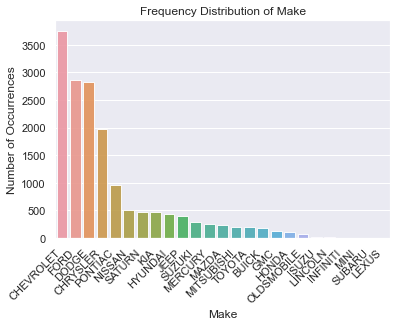

In [180]:
import seaborn as sns
import  matplotlib.pyplot as plt
%matplotlib inline 
model_count = adesa_woe_pipe.Make.value_counts()
sns.set(style="darkgrid")
chart = sns.barplot(model_count.index, model_count.values, alpha=0.9)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Frequency Distribution of Make')
plt.ylabel('Number of Occurrences')
plt.xlabel('Make')
plt.show()

resampling make feature 

In [181]:
import random
df_oversample = adesa_woe_pipe
zero_targets_counter = 0
row_list2 =[]
colist = adesa_woe_pipe["Make"].unique().tolist()
key = colist
value = random.sample(range(3,45,1), 25)
noise_dict = dict(zip(key, value))
for col , noise in noise_dict.items():   
    msk = adesa_woe_pipe["Make"] == col
    num_to_oversample =  adesa_woe_pipe["Make"].value_counts().max() - msk.sum() + noise
    df_positive_oversample = adesa_woe_pipe[msk].sample(n=num_to_oversample, replace =True)
    df_oversample = pd.concat([df_oversample, df_positive_oversample])
   
        
        

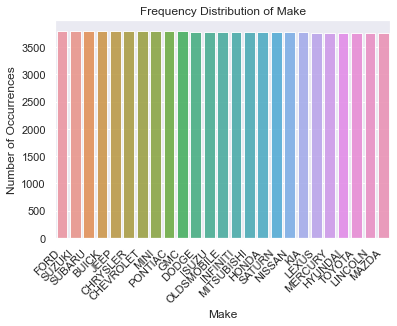

In [182]:
model_count = df_oversample["Make"].value_counts()
sns.set(style="darkgrid")
chart = sns.barplot(model_count.index, model_count.values, alpha=0.9)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Frequency Distribution of Make')
plt.ylabel('Number of Occurrences')
plt.xlabel('Make')
plt.show()

# Model  feature engineered

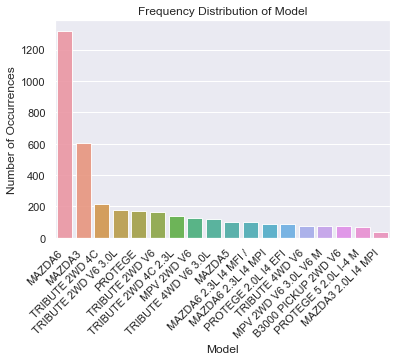

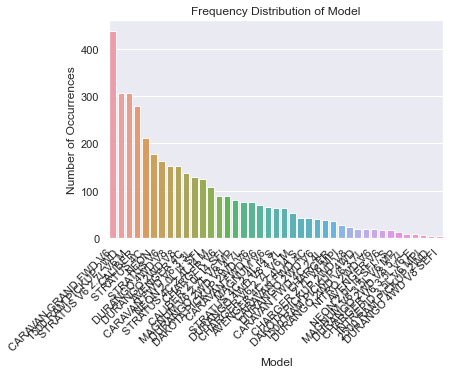

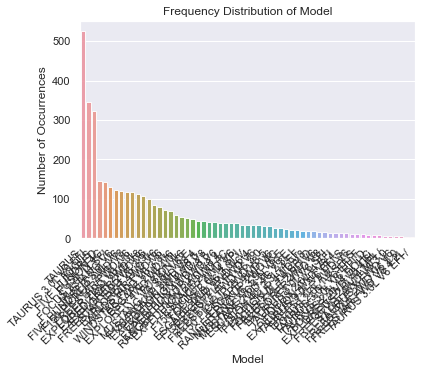

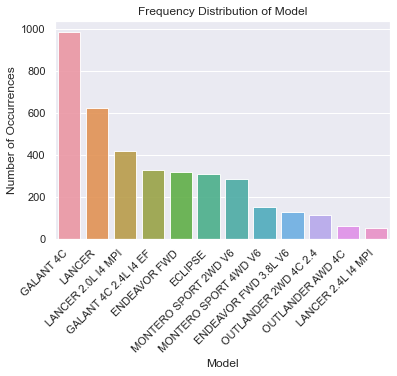

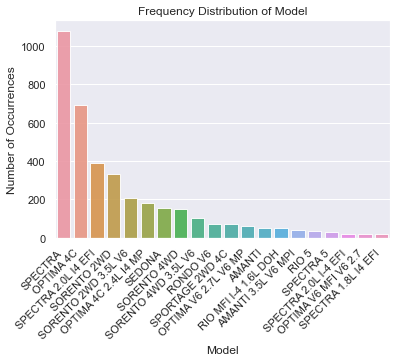

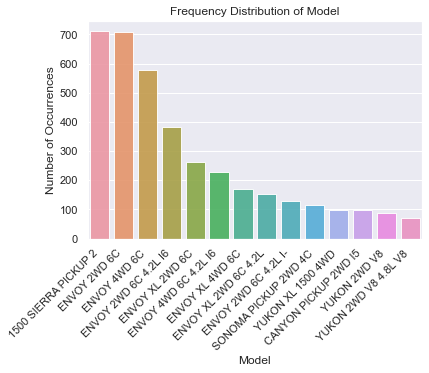

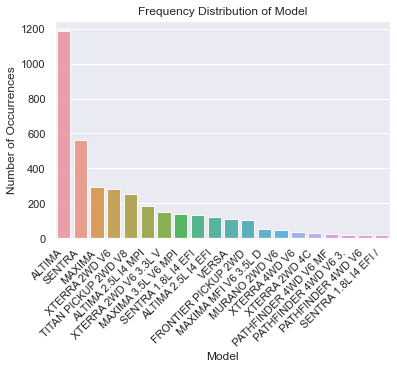

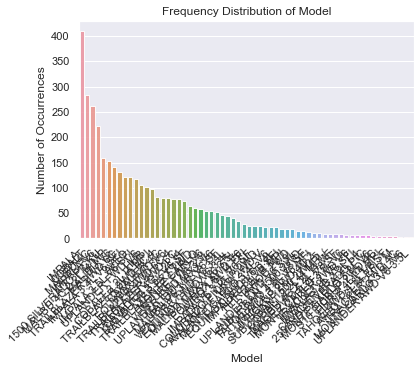

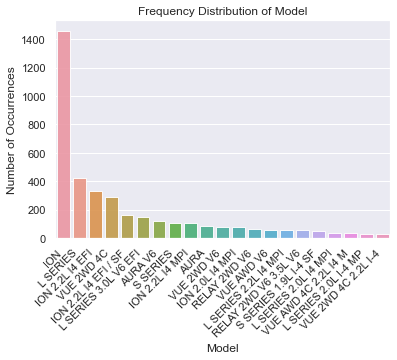

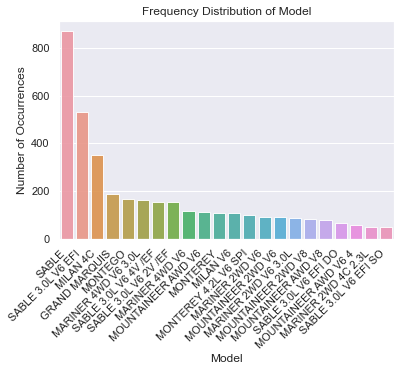

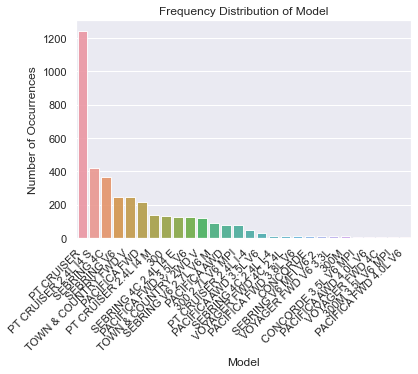

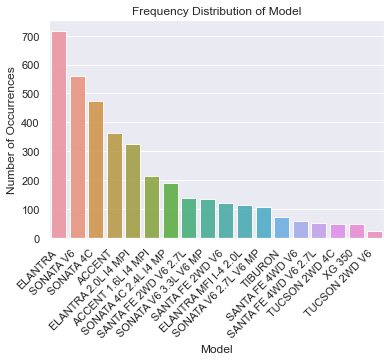

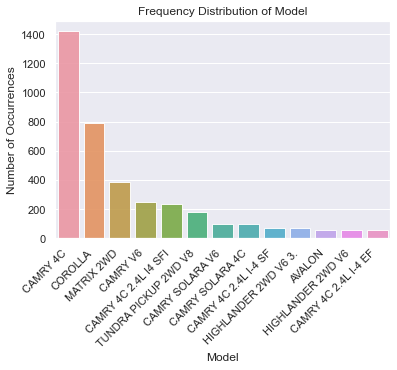

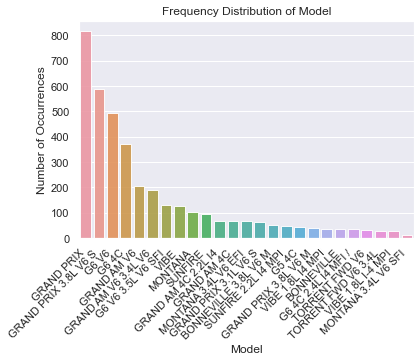

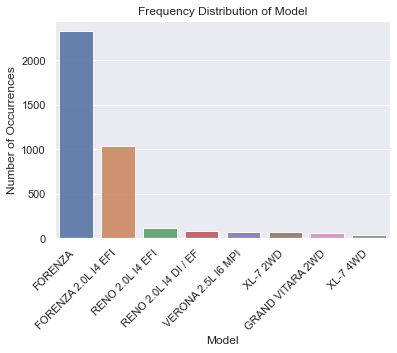

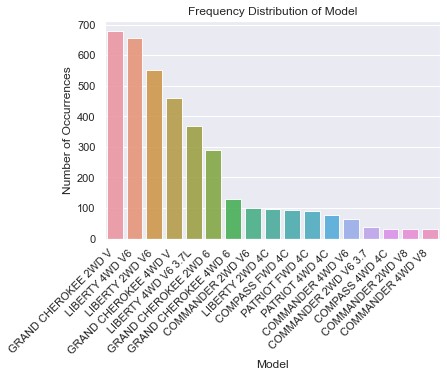

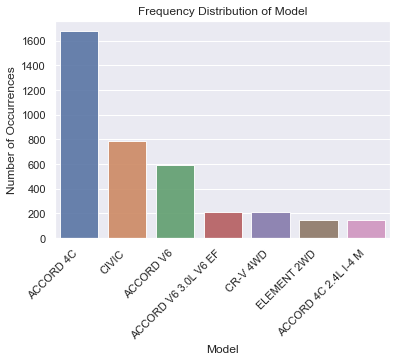

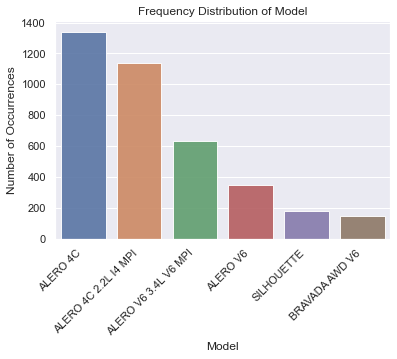

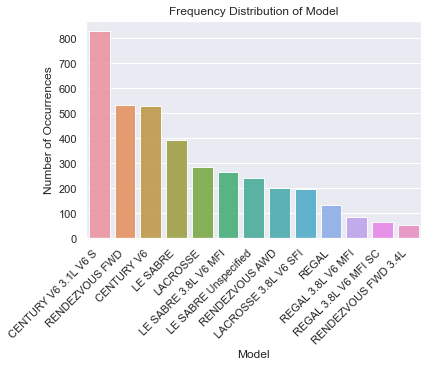

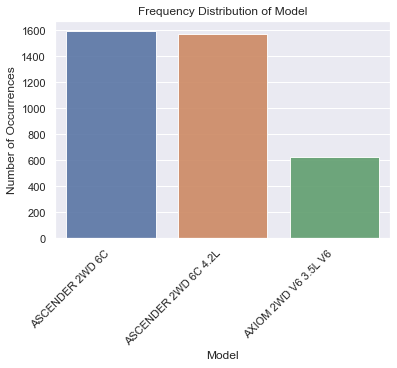

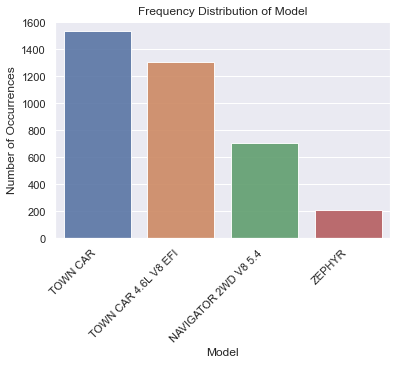

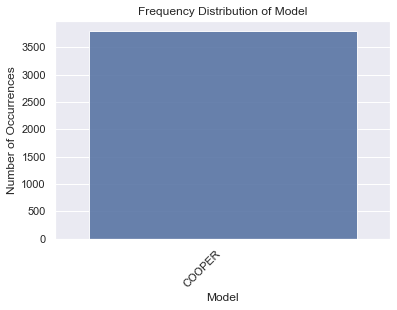

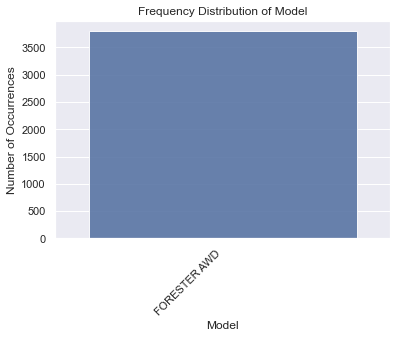

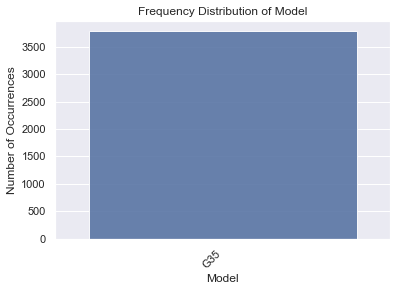

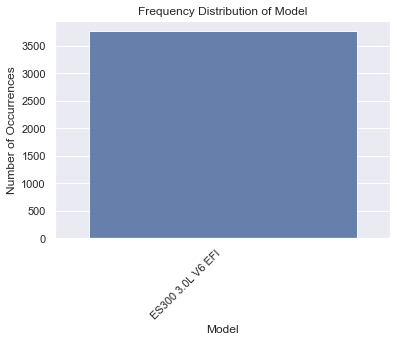

In [183]:
# initial plot of the model count
# for each make , plot the frequency distribution of its models
%matplotlib inline     
for make in df_oversample['Make'].unique():
        model_count = df_oversample['Model'][df_oversample['Make'] == make].value_counts()
        sns.set(style="darkgrid")
        chart = sns.barplot(model_count.index, model_count.values, alpha=0.9)
        chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
        plt.title('Frequency Distribution of Model')
        plt.ylabel('Number of Occurrences')
        plt.xlabel('Model')
        plt.show()

In [184]:
 # for each make, return and assign a new column with 70% threshold of cumulated total values, and set a mask as  'Other' to the remaining 10% 
for make in df_oversample['Make'].unique():
    transf_model_column,new_category_list=cumulatively_categorise(df_oversample['Model'][df_oversample['Make'] == make],threshold = 0.70, return_categories_list=True)
    df_oversample['Model'][df_oversample['Make'] == make] = transf_model_column

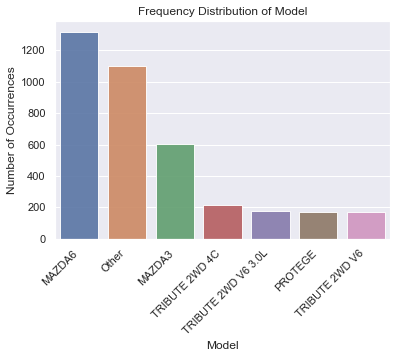

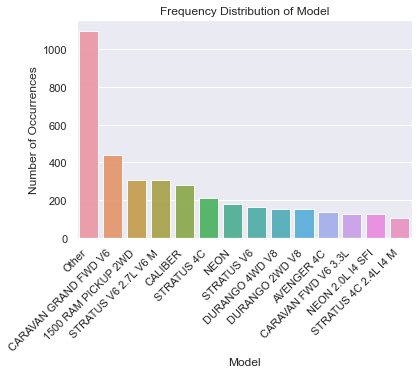

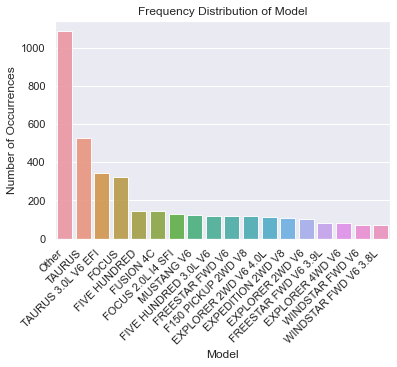

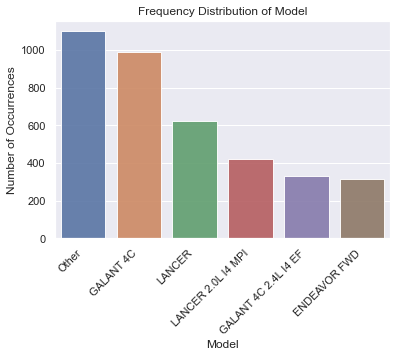

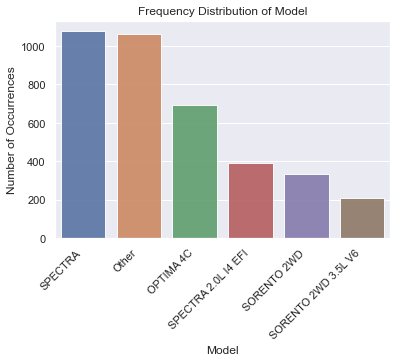

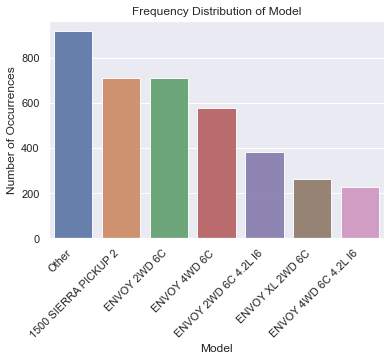

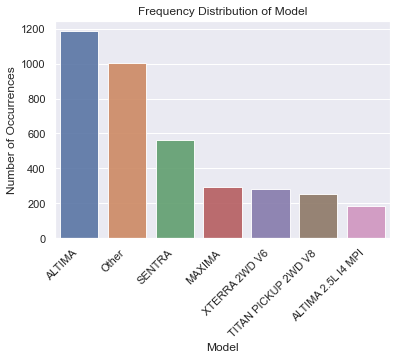

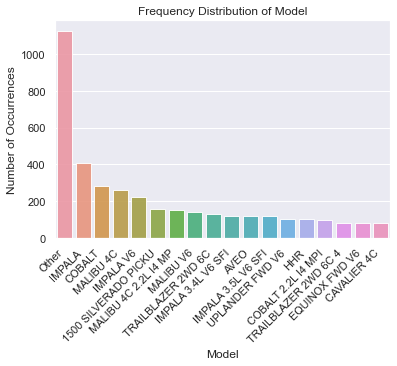

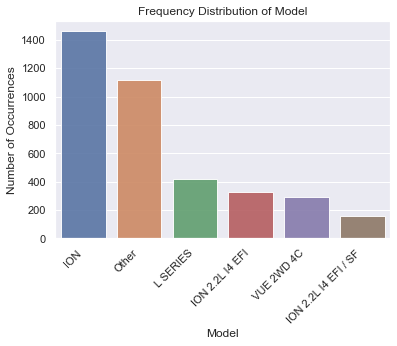

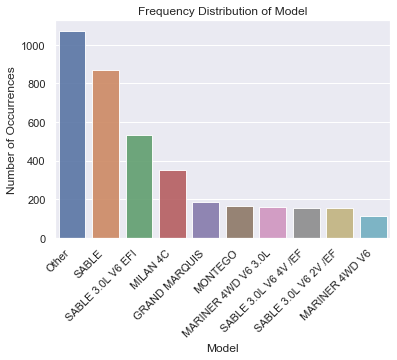

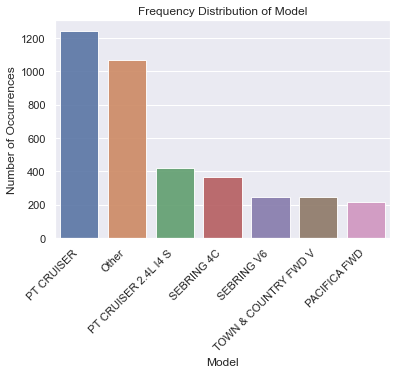

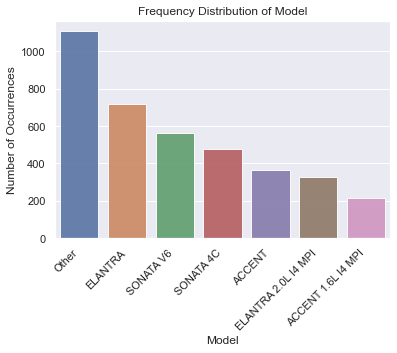

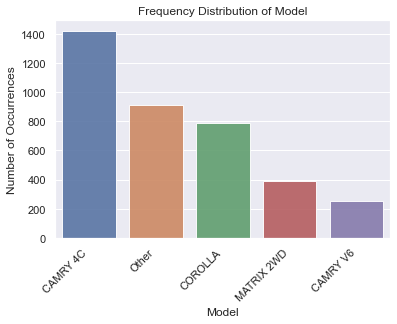

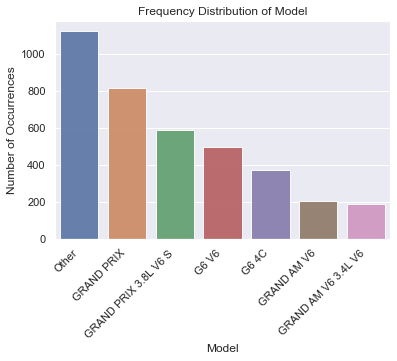

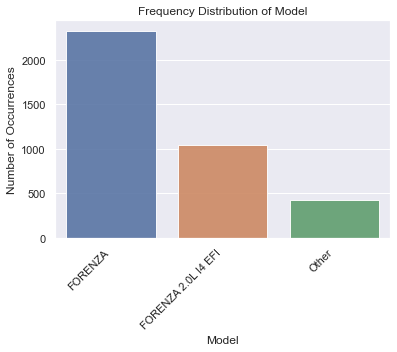

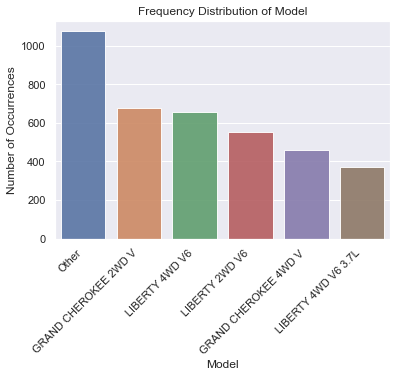

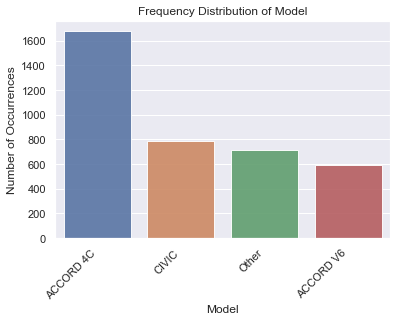

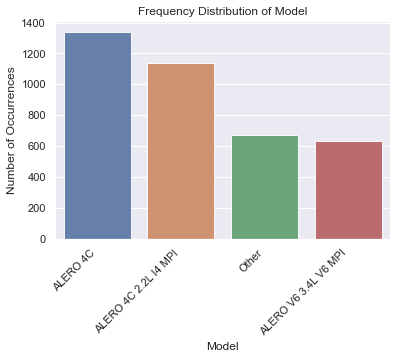

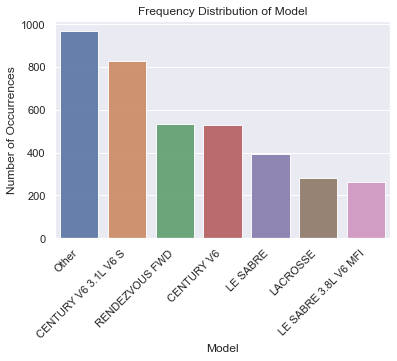

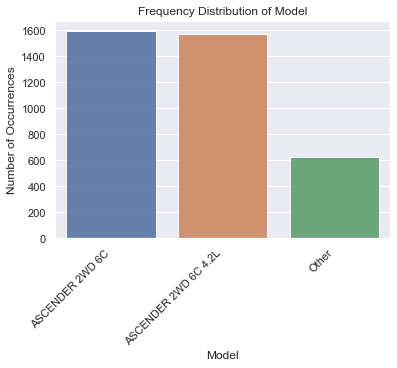

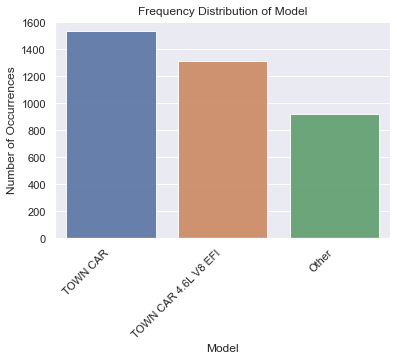

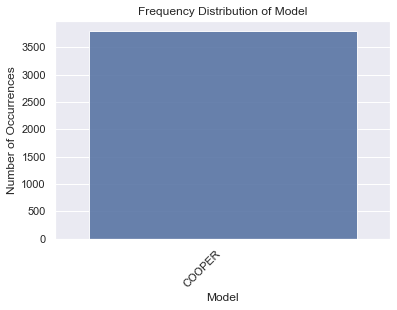

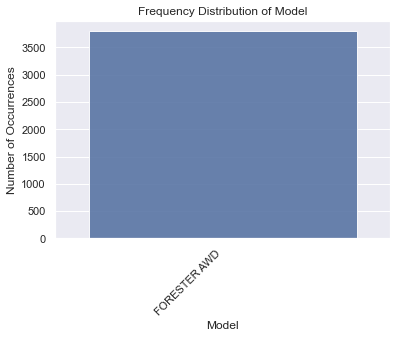

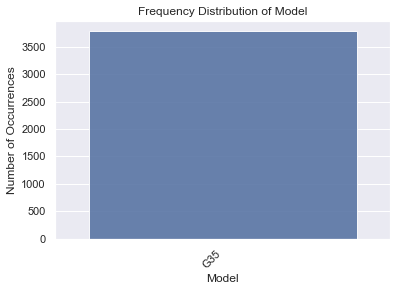

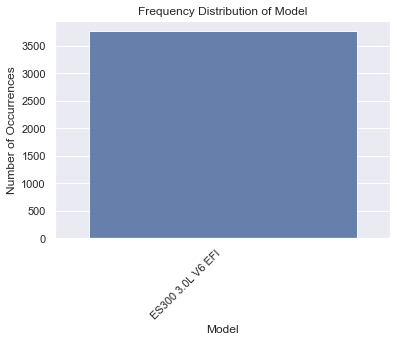

In [185]:
# Replotting with mask ('Other'): 
#for each make , plot the frequency distribution of its model
%matplotlib inline     

for make in df_oversample['Make'].unique():
        model_count = df_oversample['Model'][df_oversample['Make'] == make].value_counts()
        sns.set(style="darkgrid")
        chart = sns.barplot(model_count.index, model_count.values, alpha=0.9)
        chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
        plt.title('Frequency Distribution of Model')
        plt.ylabel('Number of Occurrences')
        plt.xlabel('Model')
        plt.show()

In [186]:
df_oversample_with_model = df_oversample
for make in df_oversample_with_model['Make'].unique():
    colist = df_oversample_with_model['Model'][df_oversample_with_model['Make'] == make].unique().tolist()
    key = colist
    value = random.sample(range(1,2*len(key),1), len(key))
    noise_dict = dict(zip(key, value))
    for col , noise in noise_dict.items():
        max_col_cvalue = df_oversample_with_model["Model"][df_oversample_with_model["Make"]== col].value_counts().max()
        mean_col_cvalue = int(df_oversample_with_model["Make"].value_counts().mean())
        if max_col_cvalue < mean_col_cvalue:    
            msk = df_oversample_with_model['Model'][df_oversample_with_model['Make'] == make] == col
            num_to_oversample =  df_oversample_with_model['Model'][df_oversample_with_model['Make'] == make].value_counts().max() - msk.sum() + noise +1
            df_positive_oversample = df_oversample_with_model[df_oversample_with_model['Make'] == make][msk].sample(n=num_to_oversample, replace =True)
            df_oversample_with_model = pd.concat([df_oversample_with_model, df_positive_oversample])
        elif max_col_cvalue > mean_col_cvalue:
            msk = df_oversample_with_model["Make"] == col
            num_to_undersample =   max_col_cvalue - int(df_oversample_with_mode["Make"].value_counts().mean()) + noise
            df_positive_oversample = df_oversample_with_model[msk].sample(n=num_to_undersample, replace =True)
            df_oversample_with_model = pd.concat([df_oversample_with_model, df_positive_oversample])

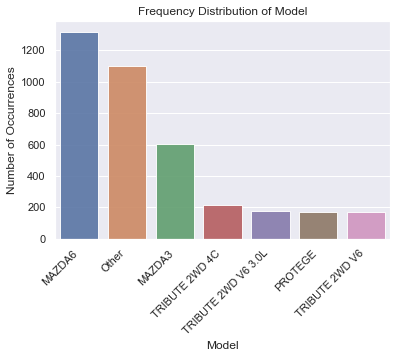

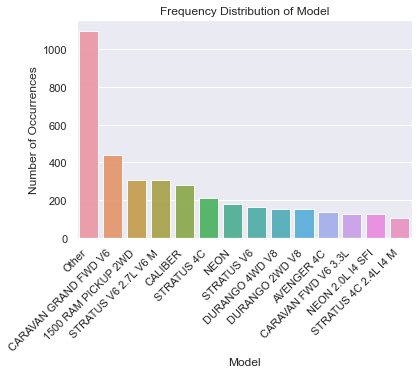

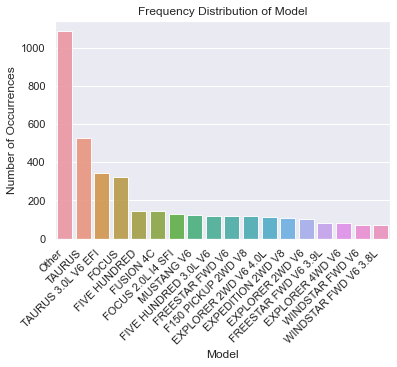

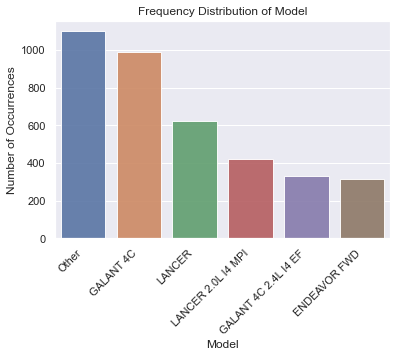

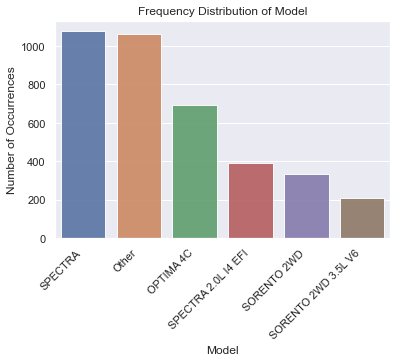

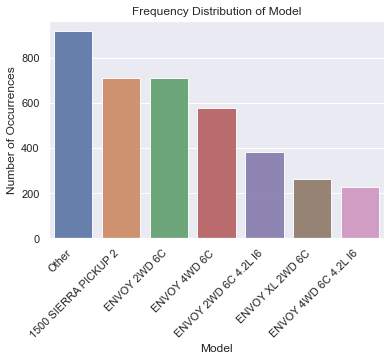

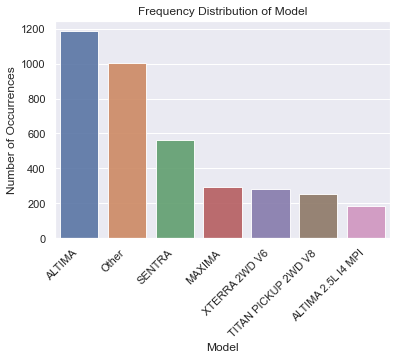

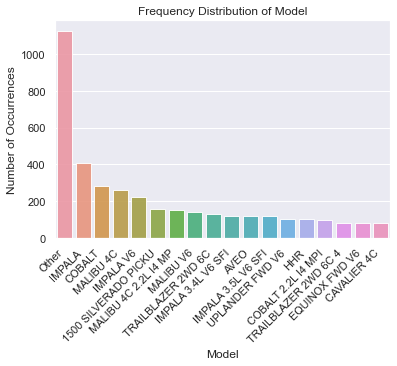

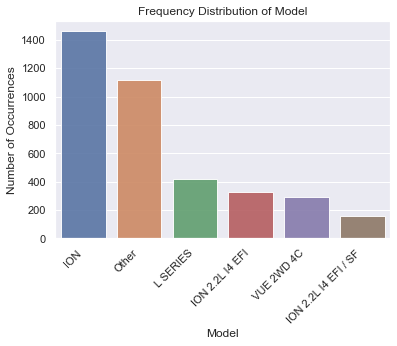

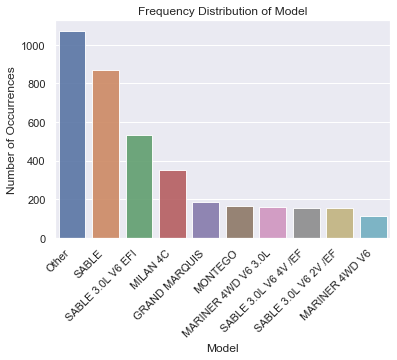

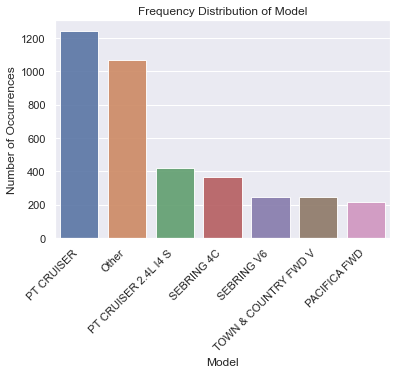

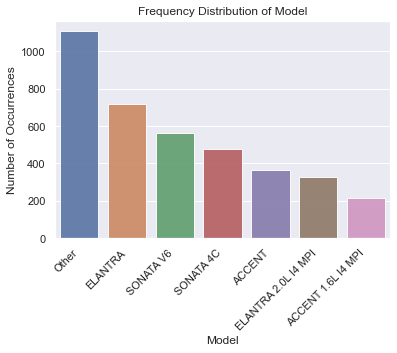

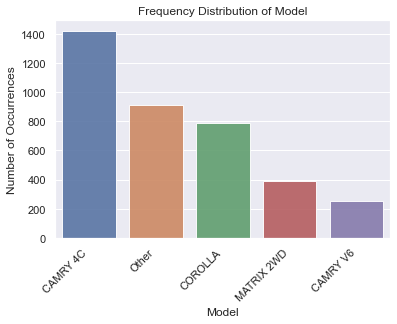

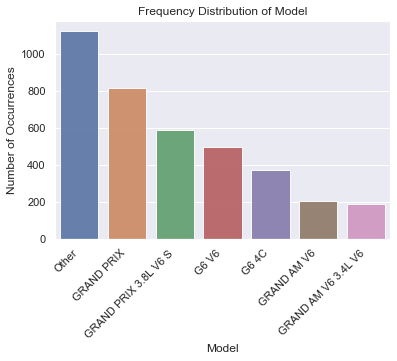

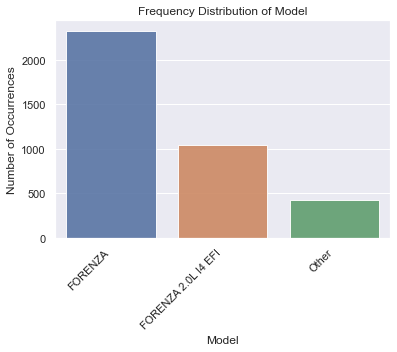

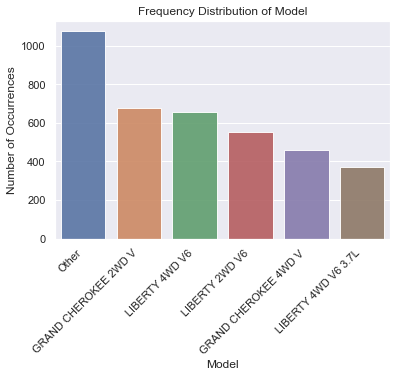

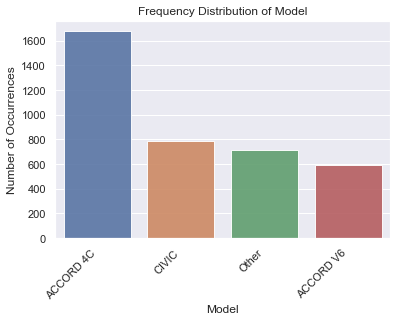

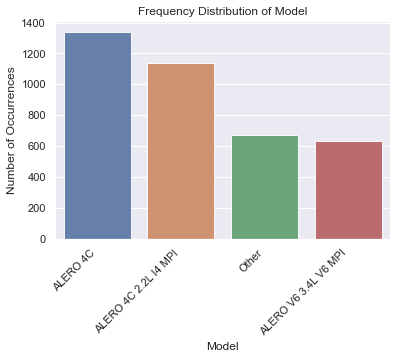

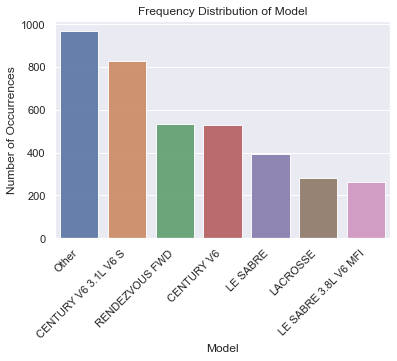

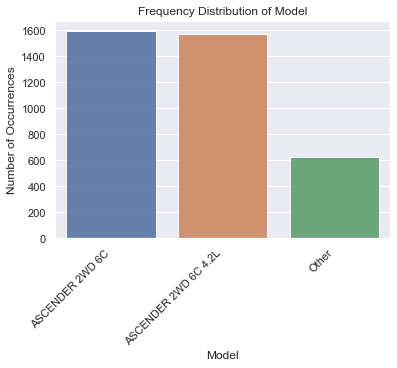

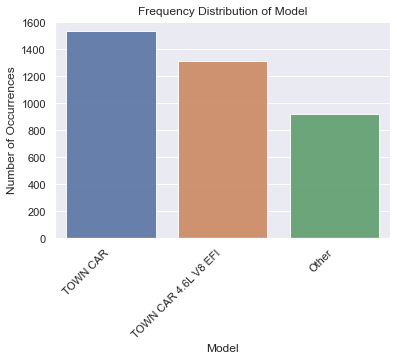

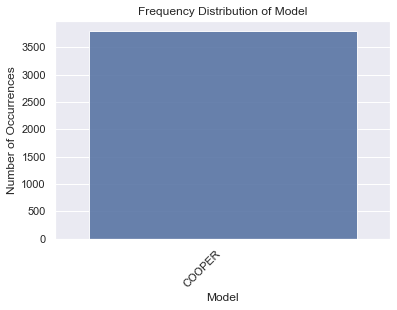

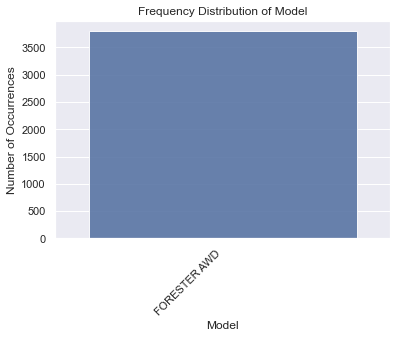

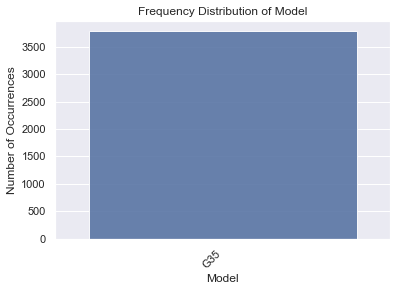

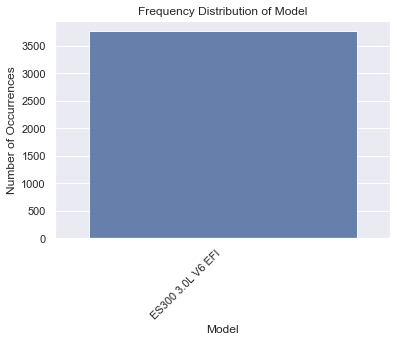

In [187]:
%matplotlib inline     
for make in df_oversample_with_model['Make'].unique():
        model_count = df_oversample_with_model['Model'][df_oversample_with_model['Make'] == make].value_counts()
        sns.set(style="darkgrid")
        chart = sns.barplot(model_count.index, model_count.values, alpha=0.9)
        chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
        plt.title('Frequency Distribution of Model')
        plt.ylabel('Number of Occurrences')
        plt.xlabel('Model')
        plt.show()

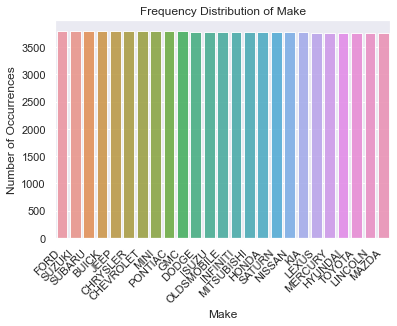

In [188]:
#recheck the make frequency distribution
%matplotlib inline     
model_count = df_oversample_with_model.Make.value_counts()
sns.set(style="darkgrid")
chart = sns.barplot(model_count.index, model_count.values, alpha=0.9)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Frequency Distribution of Make')
plt.ylabel('Number of Occurrences')
plt.xlabel('Make')
plt.show()

# Correlation Heat Map

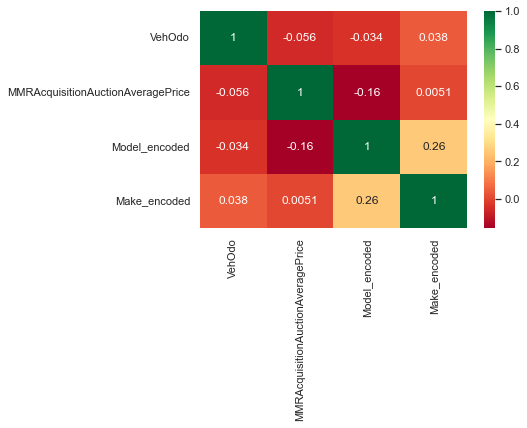

In [189]:
import seaborn as sns
#get correlations of each features in dataset
corrmat = df_oversample_with_model.drop('IsBadBuy', axis = 1).corr()
top_corr_features = corrmat.index
plt.figure()
#plot heat map
g=sns.heatmap(adesa_freq_pipe.drop('IsBadBuy', axis = 1)[top_corr_features].corr(),annot=True,cmap="RdYlGn")

### Modelization based on WOE 

In [190]:
features = df_oversample_with_model
target = df_oversample_with_model["IsBadBuy"]
x_wtrain, x_wtest, y_wtrain, y_wtest = train_test_split(features, target, test_size=0.25, random_state=0, stratify = target )

In [191]:
w_scaler = StandardScaler()
w_randomForest = RandomForestClassifier(class_weight="balanced")
w_logisticRegr = LogisticRegression(random_state=0)
w_decisionTree = DecisionTreeClassifier()

# Creating a list of pipelines for three different candidate classifiers 
woe_bench_cross = [Pipeline([("scaler",w_scaler), ('lr_classifier', w_logisticRegr)]),
                    Pipeline([('dt_classifier', w_decisionTree)]),
                    Pipeline([('rf_classifier', w_randomForest)])] 

In [192]:
# Dictionary of pipelines and classifier types for ease of reference
woe_pipe_dict = {0: 'Logistic Regression', 1: 'Decision Tree', 2: ' Default mode RandomForest'}

# Fit the pipelines
for pipe in woe_bench_cross:
    pipe.fit(x_wtrain.drop(["IsBadBuy", "Model", "Make"], axis =1), y_wtrain)

In [193]:
for i,model in enumerate(woe_bench_cross):
    print("{} with Weight of evidence Test Accuracy: {}".format(woe_pipe_dict[i],model.score(x_wtest.drop(["IsBadBuy", "Model", "Make"], axis =1),y_wtest)))

Logistic Regression with Weight of evidence Test Accuracy: 0.6445931069523245
Decision Tree with Weight of evidence Test Accuracy: 0.9521127953255991
 Default mode RandomForest with Weight of evidence Test Accuracy: 0.9562198323312727


In [194]:
best_model = w_randomForest

In [195]:
best_model.score(x_wtest.drop(["IsBadBuy", "Model", "Make"], axis =1),y_wtest)

0.9562198323312727

In [196]:
best_model.predict(x_wtest.drop(["IsBadBuy", "Model", "Make"], axis =1))

array([1, 0, 1, ..., 0, 1, 1], dtype=int64)

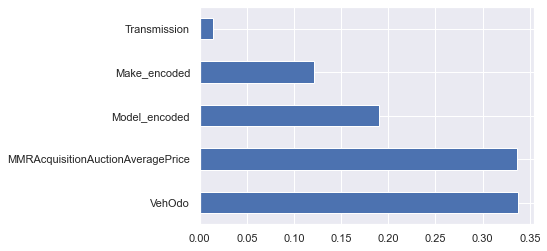

In [197]:
#plot graph of feature importances for the model
%matplotlib inline            

feat_importances = pd.Series(best_model.feature_importances_, index=x_wtest.drop(["IsBadBuy", "Model", "Make"], axis =1).columns)
feat_importances.nlargest(6).plot(kind='barh')
plt.show()

In [198]:
x_wtest['predicted_label'] = best_model.predict(x_wtest.drop(["IsBadBuy","Model","Make"], axis =1))

In [199]:
test = x_wtest.drop(["Model_encoded", "Make_encoded"], axis =1)
test.head(20)

,Model,Make,Transmission,VehOdo,MMRAcquisitionAuctionAveragePrice,IsBadBuy,predicted_label
11670,Other,HONDA,1,78387,6208.0,1,1
5353,MILAN 4C,MERCURY,1,69136,11394.0,0,0
13653,ACCORD V6,HONDA,1,75428,7059.0,1,1
2069,Other,DODGE,1,75417,9461.0,0,0
3143,MAZDA6,MAZDA,1,88236,6200.0,0,0
14136,SABLE 3.0L V6 4V /EF,MERCURY,1,75979,2970.0,1,1
8254,ELANTRA,HYUNDAI,1,79500,4539.0,1,1
13931,G35,INFINITI,1,40023,18900.0,1,1
9172,G6 4C,PONTIAC,1,63459,5561.0,0,0
625,COOPER,MINI,1,81188,8329.0,0,0


In [200]:
from sklearn.metrics import confusion_matrix
y_true = test['IsBadBuy']
y_pred = test['predicted_label']
confusion_matrix(y_true, y_pred)

array([[10751,   517],
       [  517, 11833]], dtype=int64)

In [201]:
file = open('test.pkl', 'wb')
pickle.dump(test, file)

# Results

The best pipeline between the frequency encoding and the weight of evidence encoding is  : Weight of evidence one 

The best model within that pipeline is : Logistic regression  then Upgraded Random forest models with the same score

saving the created encoding dictionnary for interpretation in the flask part

In [202]:
file = open('kidict.pkl', 'wb')
pickle.dump(woe_cat_dict, file)

saving the selected model

In [203]:
file = open('model.pkl', 'wb')
pickle.dump(best_model, file)

In [204]:
# evaluate the model per car type
# same number of car and model
#same distribution in in the train and test set = train and test stratified (same distribution per categories) , 
#keycode in train test split , double stratification
# apply a Mask , for other, reduce 

#balancing (embe learn  , data augmentation) follows startification.

# pour quel marque ca marche bien 

In [205]:
# EDA + comments